## Python Project WhiteBoard
- [PDF Instructions](./PPES-SoSe2024_StudentProject.pdf)
- [Github Repository](https://github.com/boujuan/StudentProject-Yield-Predictions-Offshore)
---
**DATA:**
- Floating Lidar Measurements from two positions = *'data/measurements/*.nc'*
- Long-term reference model data (ERA5): 1990-2023 = *'data/reanalysis/*.csv'*
- Turbine coordinates of existing wind farms = *'data/turbine-info/coordinates/existing/*.csv'*
- Turbine coordinates of planned wind farms = *'data/turbine-info/coordinates/planned_future/*.csv'*
- Turbine coordinates in operation before 2023 = *'data/turbine-info/coordinates/planned_in_operation_before_2030/*.csv'*
- Turbine coordinates planned in netherlands = *'data/turbine-info/coordinates/planned_netherlands/*.csv'*
- Geometric turbine coordinates for the areas of interest N-9.1/N-9.2/N-9.3 (not optimized – see Task 12) = *'data/turbine-info/coordinates/area_of_interest/*.csv'*
- Shapefiles of wind farm areas, the countries Denmark, Germany and the Netherlands = *'data/shapefiles/.../*'*
- Thrust and power curves of wind turbines = *'data/turbine-info/power_curves/*.csv'*
---
**TASKS:**
1. Organize all input data, filter, and read them in in a proper way
2. Plot relevant quantities (e.g. histograms, windroses, spatial plots or maps, time series, scatterplots, etc.) of the input 
data and describe potential deficiencies (e.g. data gaps).
3. Do a long-term referencing with lidar measurements and model data (ERA5) using different MCP methods 


In [1]:
# Check environment packages
from checkenv_requirements import check_and_install_packages
packages_to_check = ['numpy', 'pandas', 'netCDF4', 'matplotlib', 'cartopy']
check_and_install_packages(packages_to_check)

Python 3.10.5, Pkg manager: pip
Env: not applicable

numpy ✔, version: 1.26.4
pandas ✔, version: 2.2.2
netCDF4 ✔, version: 1.6.5
matplotlib ✔, version: 3.9.0
cartopy ✔, version: 0.23.0

All packages are installed.😇


In [2]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [8]:
Turb_dfs = pd.DataFrame([[1,2]])
print(Turb_dfs)

   0  1
0  1  2


In [3]:
import pandas as pd

# Create the original DataFrame
df = pd.DataFrame({
    'Farm power': [337.182328, 350.0],
    'Farm ambient power': [382.28241, 400.0],
    'Farm efficiency': [88.202418, 90.0],
    'Annual farm yield': [2953.717197, 3000.0]
}, index=['ut-N-9.1.', 'ut-N-9.2.'])

# Create data for the new row
new_row_data = {'Farm power': 370.0,
                'Farm ambient power': 390.0,
                'Farm efficiency': 85.0,
                'Annual farm yield': 3100.0}

# Add the new row to the DataFrame
df = df.append(new_row_data, ignore_index=True)

print(df)


KeyboardInterrupt



In [ ]:
# Function to read and extract data from netcdf files
def read_netcdf(path):
    data = nc.Dataset(path, 'r')
    return data

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [ ]:
# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

In [ ]:
# Read lidar data
lidar_files = os.listdir(lidar_path)
lidar_files = [read_netcdf(lidar_path + file) for file in lidar_files]

In [ ]:
# Print the variables of the subgroups of the groups
for subgroup in lidar_files[0]['/METEO_WLBZ_6'].groups.values():
    print(f"Subgroup: {subgroup.name}")
    # print(subgroup)
    # print("\n< VARIABLES >\n")
    for variable in subgroup.variables.values():
        print(variable.name)

Subgroup: Vaisala Weather Station
rain_accumulation
rain_duration
rain_intensity
hail_accumulation
hail_duration
hail_intensity
precipitation_count
air_temperature
relative_humidity
air_pressure
air_density
air_density_moist
PTH_count
wind_speed_average
wind_speed_min
wind_speed_max
wind_count
Subgroup: Airmar Weather Station
air_pressure
air_temperature
air_density
wind_speed_min
wind_speed_max
wind_speed_average
wind_from_direction
count


### Testing the max wind speed data from the two lidar stations

**From Buoy Meteo WLBZ 6:**
Vaisala Weather Station VS Airmar Weather Station

Max Wind Speed Data: [ 7.22  7.03  7.01 ... 15.3  12.86 11.87]


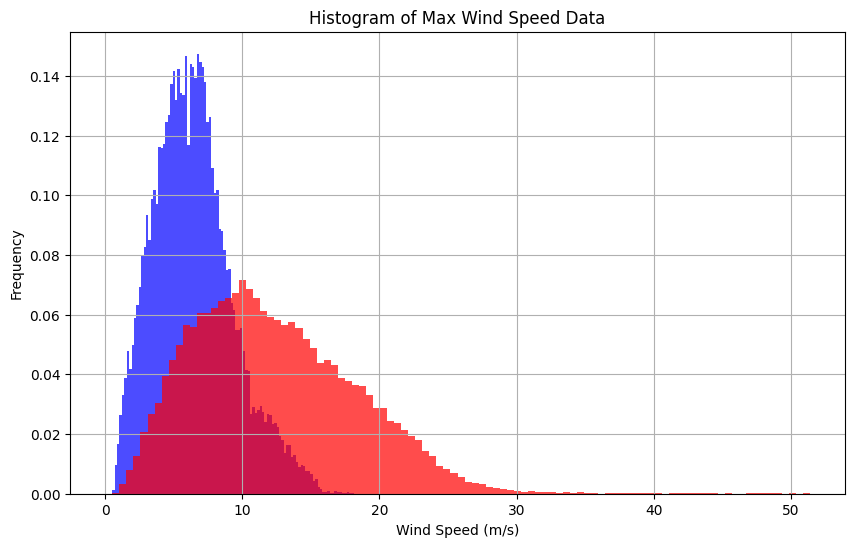

In [ ]:
# Test extracting data from variables in groups of the netcdf file
x = lidar_files[0]['/METEO_WLBZ_6']['Vaisala Weather Station']['wind_speed_max'][:]
x2 = lidar_files[0]['/METEO_WLBZ_6']['Airmar Weather Station']['wind_speed_max'][:]

# Convert to numpy array, flatten the array, and filter out NaN values
x_clean = np.array(x).flatten()
x_clean = x_clean[~np.isnan(x_clean)]
x2_clean = np.array(x2).flatten()
x2_clean = x2_clean[~np.isnan(x2_clean)]

print("Max Wind Speed Data:", x_clean)

# Plot histogram of the max wind speed data frequency
fig1 = plt.figure(figsize=(10, 6))
plt.hist(x_clean, bins=100, color='blue', alpha=0.7, density=True)
plt.hist(x2_clean, bins=100, color='red', alpha=0.7, density=True)
plt.title("Histogram of Max Wind Speed Data")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# for plotting the farm Layout
import foxes
import foxes.variables as FV
import foxes.constants as FC
#pip install foxes

Turbine 0, T0: 
Turbine 1, T1: 
Turbine 2, T2: 
Turbine 3, T3: 
Turbine 4, T4: 
Turbine 5, T5: 
Turbine 6, T6: 
Turbine 7, T7: 
Turbine 8, T8: 
Turbine 9, T9: 
Turbine 10, T10: 
Turbine 11, T11: 
Turbine 12, T12: 
Turbine 13, T13: 
Turbine 14, T14: 
Turbine 15, T15: 
Turbine 16, T16: 
Turbine 17, T17: 
Turbine 18, T18: 
Turbine 19, T19: 
Turbine 20, T20: 
Turbine 21, T21: 
Turbine 22, T22: 
Turbine 23, T23: 
Turbine 24, T24: 
Turbine 25, T25: 
Turbine 26, T26: 
Turbine 27, T27: 
Turbine 28, T28: 
Turbine 29, T29: 
Turbine 30, T30: 
Turbine 31, T31: 
Turbine 32, T32: 
Turbine 33, T33: 
Turbine 34, T34: 
Turbine 35, T35: 
Turbine 36, T36: 
Turbine 37, T37: 
Turbine 38, T38: 
Turbine 39, T39: 
Turbine 40, T40: 
Turbine 41, T41: 
Turbine 42, T42: 
Turbine 43, T43: 
Turbine 44, T44: 
Turbine 45, T45: 
Turbine 46, T46: 
Turbine 47, T47: 
Turbine 48, T48: 
Turbine 49, T49: 
Turbine 50, T50: 
Turbine 51, T51: 
Turbine 52, T52: 
Turbine 53, T53: 
Turbine 54, T54: 
Turbine 55, T55: 
Turbine 56, 

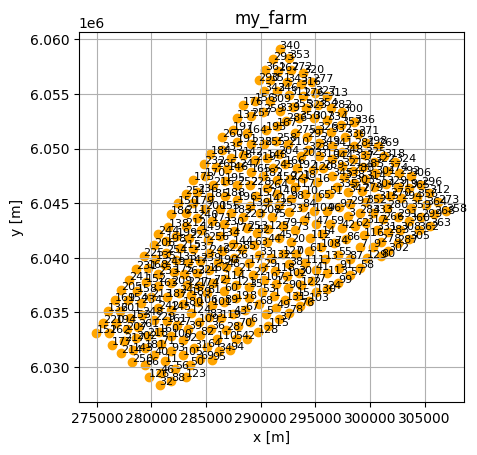

In [ ]:
# create wind farm
farm = foxes.WindFarm(name="my_farm")


current_path =  turbines_area_of_interest_path
#current_path = turbines_existing_path
#current_path = turbines_planned_future_path
#current_path = turbines_planned_in_operation_before_2030_path
#current_path = turbines_planned_netherlands_path

# get the name of files in dir
turb_files = os.listdir(current_path)

# read files in path to dataframe and put's those in list 
dfs = [read_csv(current_path + file) for file in turb_files] #read files in path to dataframe and put's those in list 
# Add turbines to wind farm via pandas DataFrame. (https://fraunhoferiwes.github.io/foxes.docs/api_input.html#foxes-input-farm-layout)
for dataframes in dfs:
    foxes.input.farm_layout.add_from_df(farm, dataframes) #

# plot Layout
ax = foxes.output.FarmLayoutOutput(farm).get_figure() 
plt.show()    

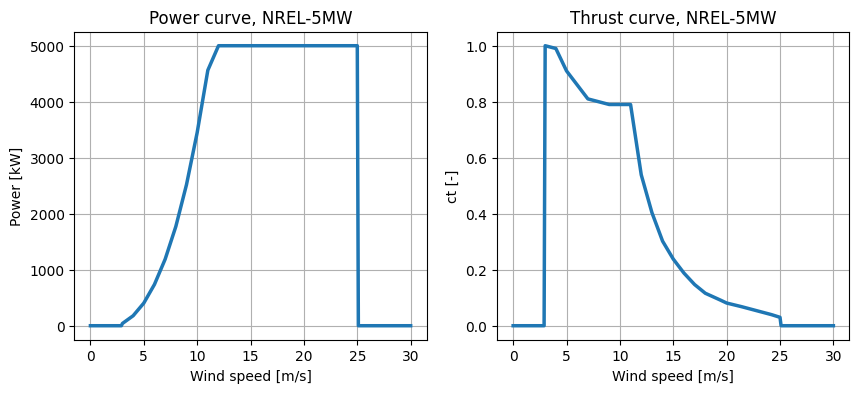

In [ ]:
# https://fraunhoferiwes.github.io/foxes.docs/notebooks/data.html#Power-and-thrust-curves
# We can add the powercurve to our foxes Model, this has a print function too

# select a turbine
Turb_Name = 'NREL-5MW'
Turb_Path = 'data/turbine-info/power_curves/NREL-5MW-D126-H90.csv'
#Turb_Name = 'IEA-15MW'
#Turb_Path = 'data/turbine-info/power_curves/IEA-15MW-D240-H150.csv'

# creat the model object
mbook = foxes.models.ModelBook()
# add a turbine and manualy add the powercurve via csv
mbook.turbine_types[Turb_Name] = foxes.models.turbine_types.PCtFile(Turb_Path)

# Plot powercurve
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
o = foxes.output.TurbineTypeCurves(mbook)
o.plot_curves(Turb_Name, [FV.P, FV.CT], axs=axs)
plt.show()